In [43]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# 数据的读取与基本信息

In [4]:
data_path = Path('/media/bnu/data/deepshare-project/project1')
raw_train_data = pd.read_csv(data_path / 'first_round_training_data.csv')
raw_test_data = pd.read_csv(data_path / 'first_round_testing_data.csv')
raw_train_data.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,...,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,...,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,...,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail


# 数据处理

## 标签分布

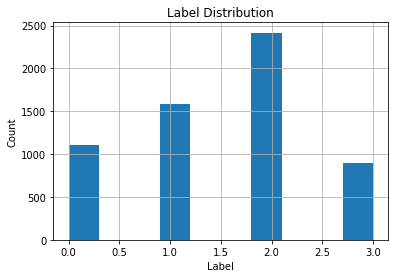

In [5]:
raw_train_data['Label'] = raw_train_data['Quality_label'].map(
    {'Excellent': 0, 'Good': 1, 'Pass':2, 'Fail':3}
)
raw_train_data['Label'].hist()
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

## 查看数据空值

In [6]:
print('Train Data:')
raw_train_data.isnull().sum()

Train Data:


Parameter1       0
Parameter2       0
Parameter3       0
Parameter4       0
Parameter5       0
Parameter6       0
Parameter7       0
Parameter8       0
Parameter9       0
Parameter10      0
Attribute1       0
Attribute2       0
Attribute3       0
Attribute4       0
Attribute5       0
Attribute6       0
Attribute7       0
Attribute8       0
Attribute9       0
Attribute10      0
Quality_label    0
Label            0
dtype: int64

In [7]:
print('Test Data:')
raw_test_data.isnull().sum()

Test Data:


Group          0
Parameter1     0
Parameter10    0
Parameter2     0
Parameter3     0
Parameter4     0
Parameter5     0
Parameter6     0
Parameter7     0
Parameter8     0
Parameter9     0
dtype: int64

## 类别数目

In [8]:
print('Train Data:')
for c in raw_train_data.columns:
    print(c, len(raw_train_data[c].unique()))

Train Data:
Parameter1 6000
Parameter2 6000
Parameter3 6000
Parameter4 6000
Parameter5 132
Parameter6 80
Parameter7 14
Parameter8 23
Parameter9 16
Parameter10 41
Attribute1 6000
Attribute2 6000
Attribute3 6000
Attribute4 600
Attribute5 553
Attribute6 394
Attribute7 702
Attribute8 565
Attribute9 626
Attribute10 565
Quality_label 4
Label 4


In [9]:
print('Test Data:')
for c in raw_test_data.columns:
    print(c, len(raw_test_data[c].unique()))

Test Data:
Group 120
Parameter1 5675
Parameter10 41
Parameter2 5675
Parameter3 5675
Parameter4 5675
Parameter5 130
Parameter6 76
Parameter7 15
Parameter8 23
Parameter9 16


## 数据分布

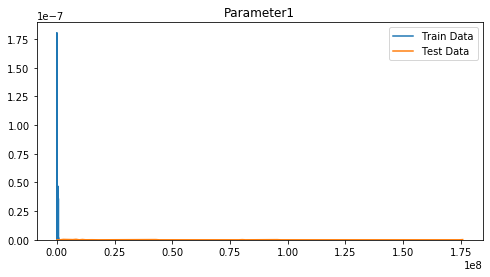

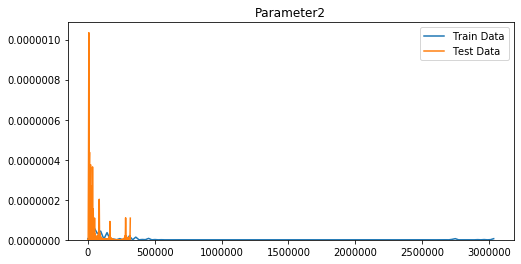

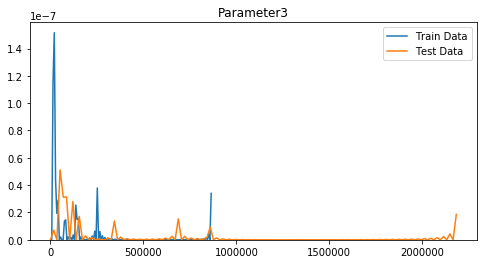

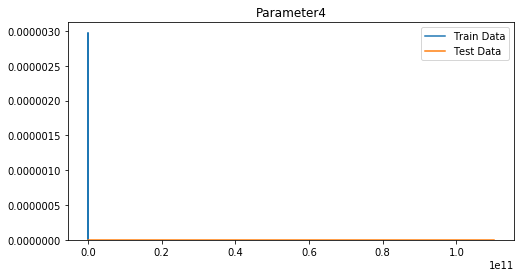

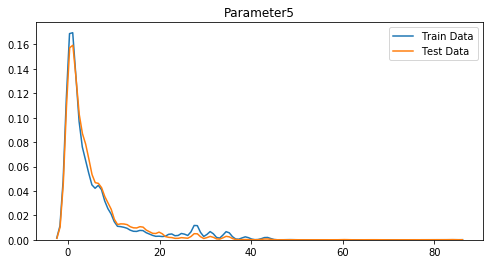

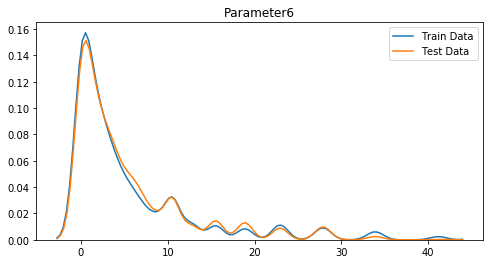

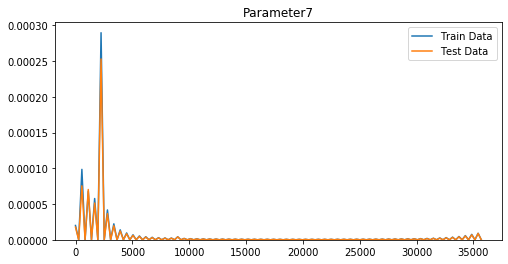

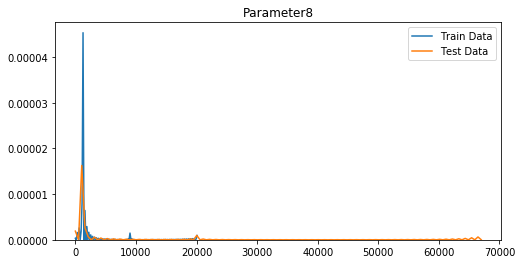

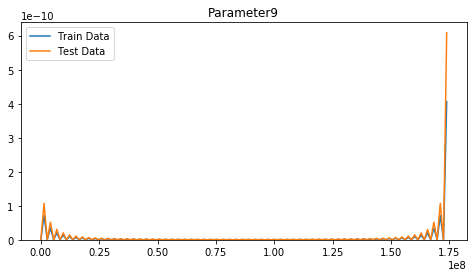

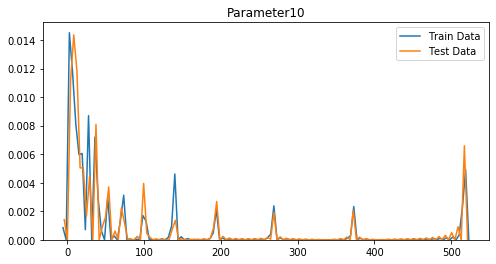

In [10]:
raw_train_data['Train'] = 1
raw_test_data['Train'] = 0
raw_data = pd.concat([raw_train_data, raw_test_data])

param_cols = raw_data.filter(regex='Parameter*').columns
for c in param_cols:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.kdeplot(raw_data[raw_data['Train'] == 1][c], ax=ax, label='Train Data')
    sns.kdeplot(raw_data[raw_data['Train'] == 0][c], ax=ax, label='Test Data')
    ax.set_title(c)
    plt.show()

从上面的密度估计图可以看出Parameter1-4在训练集和测试集中分布不同

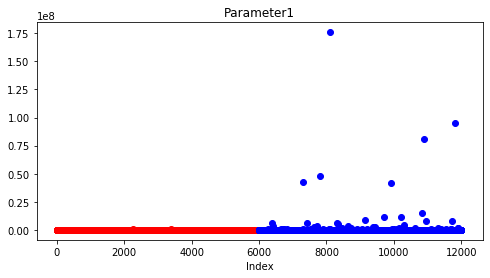

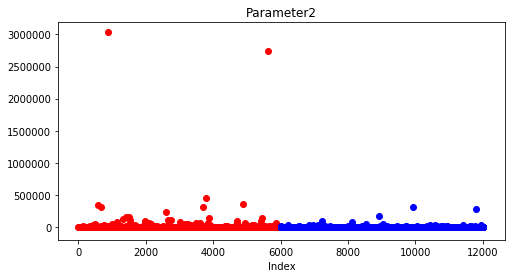

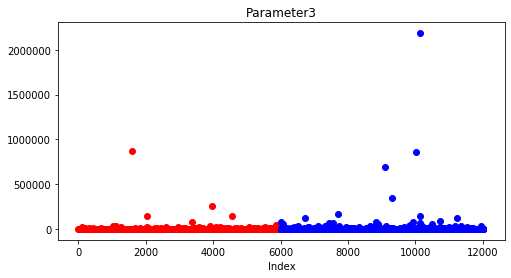

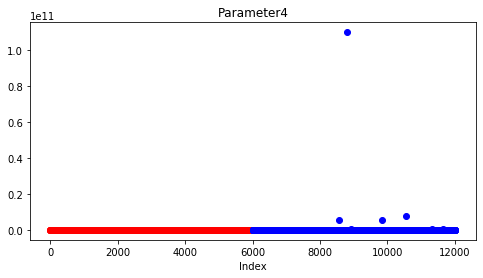

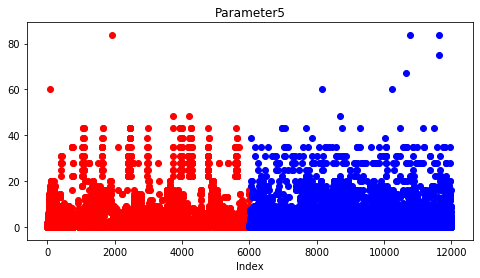

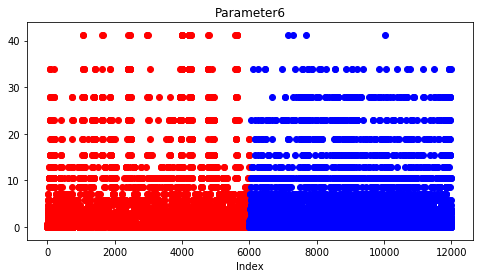

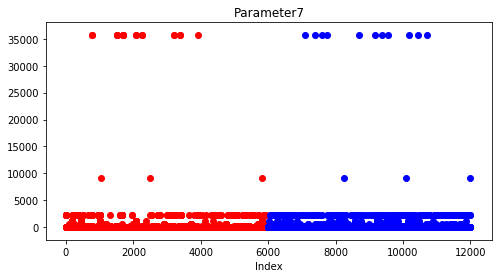

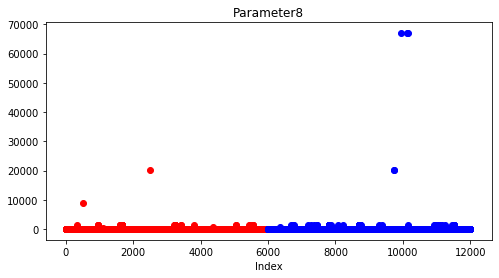

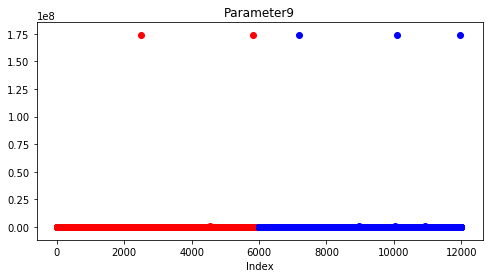

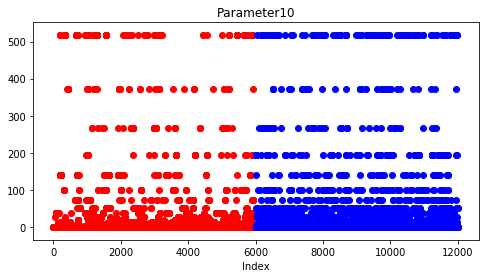

In [11]:
raw_data = raw_data.reset_index(drop=True)

for c in param_cols:
    plt.figure(figsize=(8, 4))
    plt.scatter(raw_data[raw_data['Train'] == 1].index, 
                raw_data[raw_data['Train'] == 1][c], 
                color='r')
    plt.scatter(raw_data[raw_data['Train'] == 0].index, 
                raw_data[raw_data['Train'] == 0][c], 
                color='b')
    plt.xlabel('Index')
    plt.title(c)
    plt.show()

## 数据预处理

In [21]:
def preprocess_data(raw_train_data, raw_test_data):
    raw_train_data['Train'], raw_test_data['Train'] = 1, 0
    # 合并训练集与测试集方便统一处理
    raw_data = raw_train_data.append(raw_test_data).reset_index(drop=True)
    # 对标签进行编码
    raw_data['Label'] = raw_data['Quality_label'].map(
        {'Excellent': 0, 'Good': 1, 'Pass':2, 'Fail':3}
    )
    # 处理小数位数清理部分异常值
    raw_data = np.round(raw_data, decimals=7)
    
    # 对Paramter5,7,8处理离群点
    for c, t in zip(
        ['Parameter5', 'Parameter7', 'Parameter8'],
        [50, 5000, 2000]
    ):
        raw_data.loc[raw_data[c] > t, c] = raw_data[c].mode().values[0]
    
    # 选择对Paramter5-10作为特征
    feature_cols = ['Parameter{}'.format(i) for i in range(5, 11)]
    x_train = raw_data.loc[raw_data['Train'] == 1, feature_cols].reset_index(drop=True)
    y_train = raw_data.loc[raw_data['Train'] == 1, 'Label']
    x_test = raw_data.loc[raw_data['Train'] == 0, feature_cols].reset_index(drop=True)
    
    # Paramter5,6为类别型特征，保证训练集与测试集的统一
    for c in ['Parameter5', 'Parameter6']:
        for v in x_train[c].unique():
            if v not in x_test[c]:
                x_train.loc[x_train[c] == v, c] = x_train[c].mode().values[0]

    # 根据观察Paramter7,8进行组合时效果较好
    x_train['Parameter7+8'] = x_train['Parameter7'] + x_train['Parameter8']
    x_test['Parameter7+8'] = x_test['Parameter7'] + x_test['Parameter8']
    
    return x_train, y_train, x_test
    
    
    
raw_train_data = pd.read_csv(data_path / 'first_round_training_data.csv')
raw_test_data = pd.read_csv(data_path / 'first_round_testing_data.csv')
x_train, y_train, x_test = preprocess_data(raw_train_data, raw_test_data)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(6000, 7)
(6000,)
(6000, 7)


# 模型训练

In [48]:
model_cat = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.05,
    verbose=0,
    task_type='CPU'
)
model_cat.fit(x_train, y_train)
y_pred_cat = model_cat.predict_proba(x_test)
y_pred_cat

array([[0.59759547, 0.19585997, 0.19187906, 0.01466549],
       [0.00433562, 0.16124741, 0.05346583, 0.78095115],
       [0.00433562, 0.16124741, 0.05346583, 0.78095115],
       ...,
       [0.25585175, 0.40931722, 0.31058219, 0.02424884],
       [0.17903449, 0.39295542, 0.10004791, 0.32796219],
       [0.23947014, 0.43984358, 0.29055898, 0.0301273 ]])

In [49]:
model_xgb = XGBClassifier(
    num_leaves=30,
    reg_alpha=3,
    reg_lambda=10,
    max_depth=28,
    n_estimators=200,
    objective='multiclass',
    subsample=0.7, 
    colsample_bytree=0.7,
    random_state=0,
    task_type='CPU'
)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict_proba(x_test)
y_pred_xgb

array([[0.5487205 , 0.20238616, 0.19944064, 0.04945271],
       [0.05511312, 0.18796793, 0.12723847, 0.62968045],
       [0.05511312, 0.18796793, 0.12723847, 0.62968045],
       ...,
       [0.31247696, 0.32589898, 0.3360668 , 0.02555724],
       [0.17302044, 0.3706355 , 0.09767979, 0.3586643 ],
       [0.29777986, 0.39627522, 0.24405196, 0.06189293]], dtype=float32)

In [50]:
sub_data = pd.read_csv(data_path / 'submit_example.csv')
prob_cols = [c for c in sub_data.columns if c not in ['Group']]

sub_data = raw_test_data[['Group']].copy()
for i, c in enumerate(prob_cols):
    # 简单融合
    sub_data[c] = 0.25 * y_pred_cat[:,i] + 0.75 * y_pred_xgb[:, i]
sub_data = sub_data.groupby('Group').mean()
sub_data.to_csv('../results/sub.csv')